# (5) Inject missingness into the (time-series) dataset
Insert missingness into a dataset and save the corresponding ground truth m_graph and missingness model parameters. 
We use an AFAAgent that is based on a propensity score model to model the desired missingness and sample from it. 

__Note__: Only suitable for fully observed datasets where we want to test what happens under missingness. If your dataset already has missingness, please run `prep05_define_missingness_assumptions_ts` instead to define what you know about the missing data process. 

In [1]:
%load_ext autoreload
%autoreload 2

### Define paths 

In [2]:
from afa.configurations.utils_ts import specify_default_paths_ts
# which dataset to work on 
dataset_name   = "synthetic_1"

# name for of missingness scenario 
miss_scenario  = 'MAR_1'

# original data paths
paths_gt = specify_default_paths_ts(dataset_name = dataset_name , 
                                    miss_scenario = None) 

# new missing data paths
paths_miss = specify_default_paths_ts(dataset_name = dataset_name , 
                                      miss_scenario = miss_scenario) 

# save miss model files also in ground truth folder
m_graph_adj_gt_file     = paths_miss['data_dir']  + 'm_graphs/'  + 'ground_truth/' + 'm_graph_adjacencies.csv'
ps_model_weights_gt_file   = paths_miss['data_dir']  + 'm_graphs/'  + 'ground_truth/' + 'weights.csv'

## Load dataset without missingness 
At first, we want to load the dataset

Includes loading: 
- superfeature mapping
- problem
- afa_problem 

In [3]:
from afa.data_modelling.datasets.data_loader.data_loader_ts import DataLoader_ts

2023-08-01 11:32:28.725939: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 11:32:28.870545: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-01 11:32:28.870567: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-01 11:32:29.584782: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [4]:
data_loader = DataLoader_ts(    data_file                  = paths_gt['data_file'],
                                temporal_data_file         = paths_gt['temporal_data_file'],
                                 superfeature_mapping_file = paths_gt['superfeature_mapping_file'],
                                 problem_file              = paths_gt['problem_file'],
                                 afa_problem_files         = paths_gt['afa_problem_files'],
                                 folds_file                = paths_gt['folds_file'])

dataset = data_loader.load() 

Padding sequences: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1873.54it/s]


## Define agent to induce missingness
Here we use an AFAMechanismAgent (which uses PropensityScoreModel). 
This requires defining:
- an m_graph (through an adjacency matrix) 
- weights for a logistic regression model / constant model that defines the propensity score 

### Define missing data_graph and ps_model weights

#### Option 1: Create corresponding files directly as .csv file
__m-graph__:  
Fill a .csv file containing the edges in the m_graph
- column_names: name of the superfeature missingness indicators (superR) with format 'R_' + superfeature_name
- row_names: name of the features and then name of the superR
- entry(i,j) = 1  
    if node of index i has an arrow to node of column j 
    
__ps_model_weights__: 
Fill a .csv file containing the edges in the m_graph
- column_names: name of the superfeature missingness indicators (superR) with format 'R_' + superfeature_name
- row_names: 
    - row 1: bias 
    - other rows: names of the parents 
        - entry(i,j) = 1  
            linear weight of parent on superR

#### Option 2: Define here and save
Define the adjacency matrix of the m_graph and the weights using a pandas df

In [5]:
dataset.feature_name

{'temporal': ['X0_ts', 'X1_ts', 'X2_ts', 'X3_ts'],
 'data': ['X0', 'Y'],
 'treatment': None,
 'label': ['Y_ts'],
 'super_data': ['superX0', 'superY'],
 'super_temporal': ['superX0_ts', 'superX1_ts', 'superX2_ts']}

In [6]:
from afa.data_modelling.missingness.missing_data_graph.utils import save_m_graph_adjacency_matrix
import pandas as pd
# missing data graph
# m_graph_adj = pd.DataFrame( [[0, 0], [0, 0]], 
#                             index=['X0_ts', 'X1_ts' ], 
#                             columns=['R_superX1_ts', 'R_superX2_ts'])
m_graph_adj = pd.DataFrame( [[1, 1], [1, 1], [1, 1]], 
                            index   = ['X0_ts', 'X1_ts','X2_ts' ], 
                            columns = ['R_superX1_ts', 'R_superX2_ts'])

save_m_graph_adjacency_matrix( m_graph_adj , m_graph_adj_file = m_graph_adj_gt_file  )  
m_graph_adj

,R_superX1_ts,R_superX2_ts
X0_ts,1,1
X1_ts,1,1
X2_ts,1,1


In [448]:
from afa.data_modelling.missingness.propensity_scores.utils import save_logistic_regression_ps_model_weights, load_logistic_regression_ps_model_weights
import numpy as np 
# weights for ps model 
# weights_df  = pd.DataFrame([[0.9, 0.95],[np.nan, np.nan],[np.nan, np.nan]], 
#                         index   = ['bias', 'X0_ts',  'X1_ts'], 
#                         columns = ['R_superX1_ts', 'R_superX2_ts'])
# weights_df  = pd.DataFrame([[0.2, 0.3],[0.2, 0.2],[-0.2, -0.2],[-0.2, -0.2]], 
#                         index   = ['bias', 'X0_ts',  'X1_ts', 'X2_ts'], 
#                         columns = ['R_superX1_ts', 'R_superX2_ts'])
weights_df  = pd.DataFrame([[-0.5, -0.5],[-0.5, -0.7],[0.1, -0.1],[0.1, -0.1]], 
                        index   = ['bias', 'X0_ts',  'X1_ts', 'X2_ts'], 
                        columns = ['R_superX1_ts', 'R_superX2_ts'])

save_logistic_regression_ps_model_weights(weights_df = weights_df,
                                          ps_model_weights_file = ps_model_weights_gt_file) 
weights_df

,R_superX1_ts,R_superX2_ts
bias,-0.5,-0.5
X0_ts,-0.5,-0.7
X1_ts,0.1,-0.1
X2_ts,0.1,-0.1


#### Option 3 (not recommended): Prepared m_graphs and weights 
Lastly, for specific datasets, the creation can be automatically stored using hard-coded specifications. 

In [114]:
from afa.configurations.data_settings.define_data_settings_ts import generate_m_graphs_and_weights_ts
m_graph_adj, weights_df = generate_m_graphs_and_weights_ts( dataset_name , 
                                                           miss_scenario ,  
                                                           data_dir = paths_miss['data_dir'])

In [115]:
weights_df

,R_superX1_ts,R_superX2_ts
bias,0.0,0.0
X0_ts,0.2,0.2
X1_ts,-0.2,-0.2
X2_ts,-0.2,-0.2


### Initialize a Agent (using PropensityScoreModel)

In [449]:
from afa.data_modelling.missingness.missing_data_graph.utils import load_m_graph_adjacency_matrix
from afa.data_modelling.missingness.missing_data_graph.missing_data_graph_ts import MissingDataGraph_ts
from afa.data_modelling.models.temporal_models.joint_models.utils import load_joint_model_weights_ts
from afa.data_modelling.missingness.propensity_scores.propensity_score_model_ts import PropensityScoreModel_ts
from afa.afa_models.afa_agents.afa_mechanism_agents.afa_mechanism_agent_ts import AFAMechanismAgent_ts

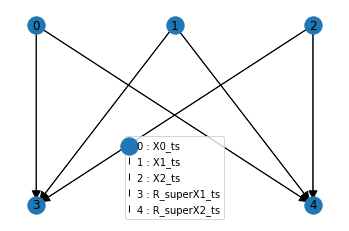

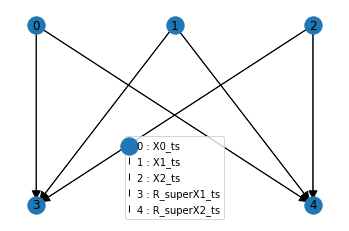

In [450]:
# 1. load m_graph 
m_graph_adj = load_m_graph_adjacency_matrix( m_graph_adj_file = m_graph_adj_gt_file )
m_graph     = MissingDataGraph_ts(   m_graph_adj  = m_graph_adj ) 

# visualize
m_graph.plot() 

In [451]:
# 2. load weights
weights_df = load_logistic_regression_ps_model_weights( ps_model_weights_file = ps_model_weights_gt_file) 

# 3. initialize params
ps_model_params = {}
# ps_model_params['base_model_params'] = {    'model_type': 'stationary_constant',
#                                                 'gt_weights': weights_df}
ps_model_params['base_model_params'] = {  'model_type' : 'static_time_series_predictor',
                                          'mode': 'online',
                                          'delay' : 1, 
                                          'gt_weights': weights_df,
                                          'base_model_static_params' : {
                                              'model_type': 'ann',
                                              'units': 1 ,
                                              'layers': 1,
                                              'learning_rate': 0.01,
                                              'epochs': 100,
                                              'checkpoint_dir': '',
                                              'mode': 'classification'
                                          }}

# 4. init ps model
ps_model_name = 'ps_model_gt'
ps_model = PropensityScoreModel_ts( name            = ps_model_name, 
                                    m_graph         = m_graph, 
                                    feature_name    = dataset.feature_name,
                                    superfeature_mapping = dataset.superfeature_mapping, 
                                    target_superfeature_names    = dataset.afa_problem.target_superfeature_names,
                                    model_params    = ps_model_params ) 

1/1 [==============================] - 0s 363ms/step - loss: 0.6931 - binary_accuracy: 1.0000
Set weights for ann ...
1/1 [==============================] - 0s 369ms/step - loss: 0.6931 - binary_accuracy: 1.0000
Set weights for ann ...


In [452]:
afa_agent = AFAMechanismAgent_ts(  name      = miss_scenario + '_agent',
                                       ps_model  = ps_model 
                                 )

## Create new dataset using the defined agent

Run the agent as an afa agent over the dataset to create an afa_dataset. Then create a new regular dataset out of it

In [453]:
from afa.afa_datasets.afa_dataset_ts import AFADataset_ts

In [454]:
afa_results = afa_agent.predict(dataset, 
                                ids = None, 
                                fold = None, 
                                split = None,  
                                n_samples = 1) 

# create an afa_dataset out of the generated afa_results
afa_dataset = AFADataset_ts(  dataset = dataset, model = afa_agent, results = afa_results) 

# check retrieving data 
data = afa_dataset.get_data( fold = None, split = None, n_samples = 1) 

4/4 [==============================] - 0s 2ms/step


Convert superR to R: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2938.22it/s]

7/7 [==============================] - 0s 1ms/step



Convert superR to R: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2773.09it/s]


10/10 [==============================] - 0s 2ms/step


Convert superR to R: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1862.07it/s]


13/13 [==============================] - 0s 2ms/step


Convert superR to R: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1167.03it/s]

16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 1ms/step


Convert superR to R: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1447.81it/s]


In [455]:
#afa_dataset.get_data()['superR']

In [456]:
dataset_new =  afa_dataset.create_new_dataset()

Inserting missingness into dataframe: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 705.05it/s]

Missingness inserted.


In [457]:
dataset_new.temporal_feature

array([[[ 0.61743928,         nan,         nan,         nan],
        [-0.33474081, -1.6924591 ,  0.04955291,  0.11848464],
        [-1.16441813,         nan,  0.0437944 , -0.44166684],
        [ 1.84896   ,  1.15871851,         nan,         nan],
        [-1.43519133,         nan,         nan,         nan]],

       [[-0.11267769,         nan, -1.14818601, -0.34655639],
        [ 0.97614517,         nan,         nan,         nan],
        [-0.9194451 ,         nan,  0.51515878,  0.77957249],
        [ 1.38451107,  1.24311641,         nan,         nan],
        [-0.7392126 , -0.82291527,         nan,         nan]],

       [[-0.58332277,         nan,         nan,         nan],
        [ 1.08142327, -0.26928017, -1.0755377 , -0.31283029],
        [-1.33529314,         nan, -1.84792448, -0.05481668],
        [-0.8359606 ,  0.39913469,         nan,         nan],
        [ 2.5634141 ,  1.10150895,         nan,         nan]],

       ...,

       [[ 0.43219104, -2.21907029,         nan,    

In [458]:
(np.isnan(dataset_new.temporal_feature).sum(axis = 1).sum(axis = 1) == 20).sum()

0

## Visualize newly created missingness 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


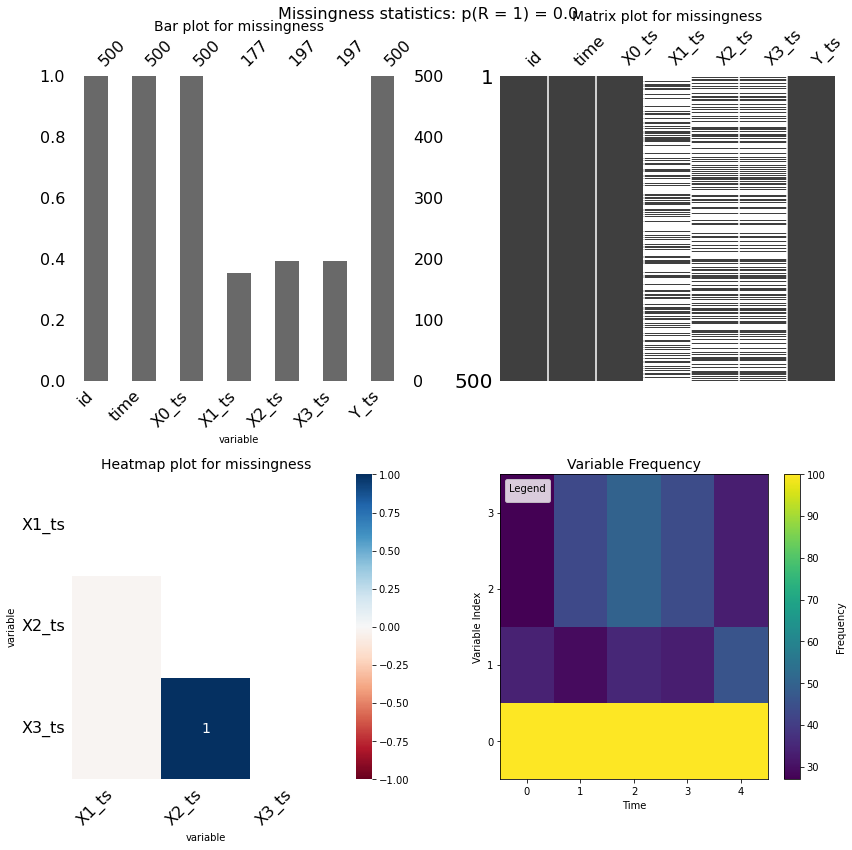

In [459]:
fig = dataset_new.plot_missingness_stats()

## Add the ground truth propensity score to the dataset

For comparison reasons we might be interested in the ground truth propensity score and add it back to dataset_new 

In [460]:
from afa.data_modelling.missingness.missingness_model import MissingnessModel

In [461]:
# compute ps values
R_samples, ps_values_1 = ps_model.predict(dataset_new)

16/16 [==============================] - 0s 1ms/step


In [462]:
# check consistency 
ps_values_1_mean =  ps_values_1.prod(axis = 1).mean()
print("Mean of propensity score values: {}".format(ps_values_1_mean))
R_samples_1_mean = R_samples.prod(axis=1).prod(axis=1).mean()
print("Mean of R_samples = 1: {}".format(R_samples_1_mean))

Mean of propensity score values: 7.296246676087997e-05
Mean of R_samples = 1: 8e-05


In [463]:
ps_values_1.prod(axis = 1)

array([5.95115364e-05, 2.02290844e-05, 5.10717065e-05, 7.80787171e-05,
       1.00986249e-04, 7.87963033e-05, 1.53884882e-05, 6.78331970e-06,
       8.24962724e-05, 6.80839322e-05, 2.26823730e-04, 1.96099959e-05,
       3.43573588e-04, 5.79507051e-05, 5.84270522e-05, 1.76470709e-04,
       1.17427306e-04, 1.52944130e-05, 8.30944287e-05, 6.01392724e-05,
       8.44389963e-05, 8.92405278e-05, 4.79462301e-05, 5.85314184e-05,
       5.72826848e-05, 2.06935056e-05, 5.82548549e-05, 3.25510713e-05,
       1.56610021e-05, 1.28986385e-04, 3.73517339e-05, 4.40952788e-05,
       1.17829981e-04, 2.27907327e-05, 2.86667121e-05, 4.26938684e-05,
       5.08978286e-05, 5.85712193e-05, 5.82901344e-05, 1.16805625e-04,
       2.10623667e-05, 2.10539136e-04, 1.67318650e-05, 8.56225752e-05,
       3.59068989e-05, 9.88848138e-05, 5.92201674e-05, 6.15264576e-05,
       5.84005069e-05, 5.80303591e-05, 5.85027290e-05, 5.82833381e-05,
       3.45688645e-05, 1.79683096e-05, 6.14439260e-05, 2.01961391e-04,
      

In [416]:
# init miss_model in dataset
miss_model = MissingnessModel(m_graph)
dataset_new.miss_model = miss_model 

In [417]:
# add to dataset
dataset_new.miss_model.add_ps_values( ps_model_name , 
                                      R_samples = R_samples, 
                                      ps_values_1 = ps_values_1 )

## Save the new dataset

In [248]:
dataset_new.save( data_dir = paths_miss['data_dir'], 
                  dataset_name = dataset_name + '_' + miss_scenario, 
                  save_folds = True) 

In [ ]:
dataset_new.miss_model.save(paths_miss['data_dir'])

## Reporting: summarize the whole dataset (with missingness) 
Store information in reports folder in latex / markdown format.

In [ ]:
# reporting
explanation_file = paths_miss['data_dir'] + 'dataset_report'
dataset_new.explain(file=  explanation_file + '.md', format = 'markdown')
# dataset_new.explain(file=  explanation_file + '.tex', format = 'latex')